# The 3 sites Bose Hubbard model via Skolem Tridiagonalization 

In [134]:
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal, expm, norm

from tqdm.notebook import tqdm, trange
import time

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.tools.evolution import expm_multiply_parallel

## Number theoretical tools: The Skolem polynomials and its inverse

In [108]:
def combinadics_from_index(N, k):
    """
    This function converts a natural number N as sequences of k-combinations. 
    This is referred to as the combinatorial number system of degree k (for some positive integer k).
    
    See https://planetcalc.com/8592/
    """
    combinadics = [0] * k
    
    c_start = max(N, k)
    
    for j in range(k, 0, -1):
        #############################################################
        # Find the value of c using the bisection method.
        # This part was generated by ChatGPT
        #############################################################
        left = 0
        right = c_start + 1  # Increase the range by 1 to include c_start
        while left < right:
            mid = (left + right) // 2
            q = comb(mid, j)
            if q <= N:
                left = mid + 1
            else:
                right = mid
        c = left - 1  # Return the previous value since q > N
        #############################################################
        
        q = comb(c, j)
        c_start = c - 1
        N -= q
        combinadics[k - j] = c
    
    return combinadics

def index_from_combinadics(combinadics):
    """
    This function returns index from the combinadics.
    
    Note:
        assert index_from_combinadics(combinadics_from_index(N, k)) == N
    """
    return sum(
        comb(c, j + 1) for j, c in enumerate(reversed(combinadics))
    )

def skolem(ntuple):
    """
    Evaluate the Skolem polynomial from tuple
    """
    return int(sum(
        comb(sum(ntuple[:k]) + k - 1, k) for k in range(1, len(ntuple) + 1)
    ))

def tuple_from_skolem(S, k):
    "The inverse of the Skolem polynomials"
    
    combinadics = combinadics_from_index(S, k)
    
    assert index_from_combinadics(combinadics) == S

    ntuple = [0] * k
    
    ntuple[0] = combinadics[-1]
    
    for j in range(1, k):
        ntuple[j] = combinadics[k - j - 1] - j - sum(ntuple[:j])
    
    return ntuple

## Parameters of the 3 sites Bose Hubbard model and propagation

In [120]:
U = 1
J = 1
mu = 0

Δt = 0.0001


# The number of propagation time steps is 2 ** lg2_ntimes 
lg2_ntimes = 15

# final time
T_final = Δt * 2 ** lg2_ntimes

# number of bosons
N = 200

## Using the Skolem for building the propagator  the Bose Hubbard model 

In [121]:
# the cut off of Skolem index
S_min = skolem([0, 0, N])
S_max = skolem([N, 0, 0])

skolem_321 = np.arange(S_min, S_max + 1)

# This ordering is to be compartible with QuSpin
n3, n2, n1 = np.array(
    [tuple_from_skolem(S, 3) for S in skolem_321]
).T

## Reindex (n3, n2, n1) <-> (n1, n2, n3)
indx = np.array([
    skolem(_) for _ in zip(n1, n2, n3)
]) - S_min

### Get $\exp(-i\Delta t \hat{H}_{23})$ via tridiagonalization

In [122]:
t0 = time.time()

E_23_tridiag, v = eigh_tridiagonal(
    0.25 * U * n2 * (n2 - 1) - 0.5 * mu * n2 + 0.5 * U * n3 * (n3 - 1) - mu * n3,
    -J * np.sqrt((n2 + 1) * n3)[1:],
)

expH_23_tridiag = (v * np.exp(-1j * Δt * E_23_tridiag)) @ v.T

print( time.time() - t0)

### Get the desired propagation via a la the Scaling and Squaring Method

In [135]:
t0 = time.time()

# the split operator method 
propagator_U_Δt = expH_23_tridiag @ expH_23_tridiag[indx, :][:, indx]

# the recursively squaring to get to the desired final time
propagator_U = propagator_U_Δt.copy()

for _ in trange(lg2_ntimes):
    propagator_U = propagator_U @ propagator_U

print( time.time() - t0)

  0%|          | 0/15 [00:00<?, ?it/s]

573.5942666530609


In [157]:
from scipy.sparse import coo_matrix

In [158]:
coo_matrix(v)

KeyboardInterrupt: 

In [155]:
np.sum(np.abs(propagator_U_Δt) < 1e-5) / propagator_U_Δt.size

0.9994717912247434

In [159]:
np.sum(np.abs(v) < 1e-6) / v.size

0.9987819516464393

## QuSpin

Comparing the implementation of the Bose-Hubbard Model in the QuSpin library by following: https://github.com/weinbe58/QuSpin/blob/master/examples/notebooks/BHM.ipynb

In [124]:
##### construct Bose-Hubbard Hamiltonian #####
# define boson basis with N states per site L bosons in the lattice
L = 3
basis = boson_basis_1d(3, Nb=N) # full boson basis

# define site-coupling lists
#hop=[[-J,i,(i+1)%L] for i in range(L)] #PBC
hop=[[-J,i,(i+1)%L] for i in range(L - 1)] # open boundary condition
interact=[[0.5*U,i,i] for i in range(L)] # U/2 \sum_j n_j n_j
pot=[[-mu-0.5*U,i] for i in range(L)] # -(\mu + U/2) \sum_j j_n

# define static and dynamic lists
static=[['+-',hop],['-+',hop],['n',pot],['nn',interact]]
dynamic=[]

# build Hamiltonian
H=hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

# print(n1, n2, n3)

Hermiticity check passed!
Particle conservation check passed!


/home/denys/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.boson.boson_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian


In [139]:
ψ0 = np.zeros(len(basis.states), complex)
ψ0[0] = 1

In [140]:
t0 = time.time()

U_Δt_qspin = expm_multiply_parallel(H.tocsr(), a = -1j * T_final)
ψ_qspin = U_Δt_qspin.dot(ψ0)

print( time.time() - t0)

57.61420273780823


In [141]:
ψ_skolem = propagator_U @ ψ0

In [147]:
np.abs(ψ_qspin - ψ_skolem).max()

5.401638250217025e-06

In [149]:
norm(ψ_qspin - ψ_skolem)

5.487449028178483e-06

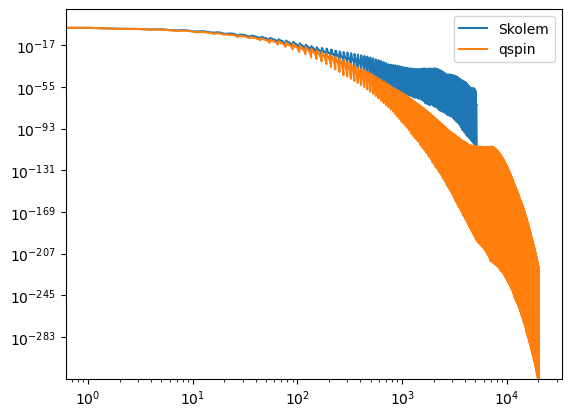

In [146]:
plt.loglog(np.abs(ψ_skole), label='Skolem')
plt.loglog(np.abs(ψ_qspin), label='qspin')
plt.legend()

### $\hat{H}_{23}$ via QuSpin

Hermiticity check passed!
Particle conservation check passed!


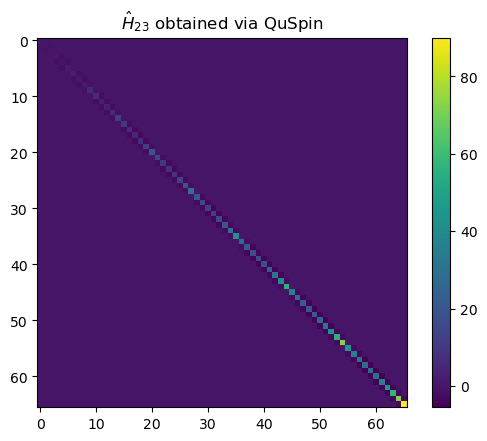

In [31]:
H_23 = hamiltonian(
    [
        ['+-', [[-J, 1, 2]]], 
        ['-+', [[-J, 1, 2]]], 
        ['nn', [[0.5 * U, 1, 1], [U, 2, 2]]], 
        ['n', [[-0.5 * U, 1], [-U, 2]]]
    ], 
    [], 
    basis = basis, 
    dtype = np.float64,
    check_symm = False
)

plt.title("$\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_23.todense())
plt.colorbar()
plt.show()

compare

In [30]:
np.allclose(
    expH_23_tridiag, 
    expm(-1j * Δt * H_23.todense())
)

False

### $\hat{H}_{12}$ via QuSpin

In [8]:
H_12 = hamiltonian(
    [
        ['+-', [[-J, 0, 1]]], 
        ['-+', [[-J, 0, 1]]], 
        ['nn', [[U, 0, 0], [0.5 * U, 1, 1]]], 
        ['n', [[-U, 0], [-0.5 * U, 1]]]
    ],
    [], 
    basis = basis, 
    dtype = np.float64,
    check_symm = False
)

Hermiticity check passed!
Particle conservation check passed!


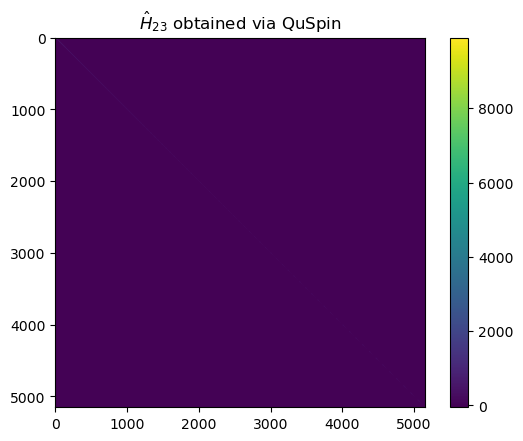

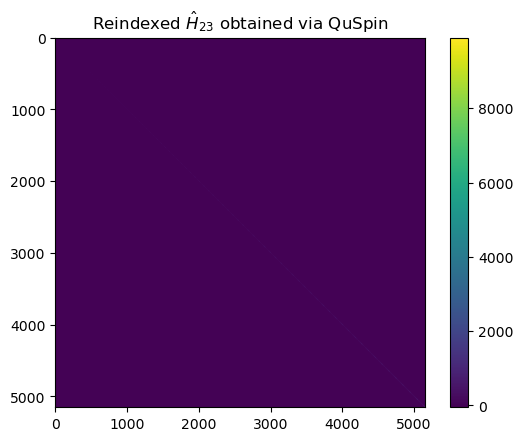

In [9]:
plt.title("$\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_12.todense())
plt.colorbar()
plt.show()

plt.title("Reindexed $\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_12.todense()[indx, :][:, indx])
plt.colorbar()
plt.show()


Comparing 

In [10]:
np.allclose(
    expH_23_tridiag[indx, :][:, indx], 
    expm(-1j * Δt * H_12.todense())
)

True